In [37]:
import sys
import os
import cv2
import math
import json
import copy
import requests
import warnings
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.models as models
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from os import listdir
from os.path import isfile, join

from sklearn.metrics import pairwise
from scipy.spatial import distance
import torch
from torch import nn
from torch.optim import Optimizer, SGD
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms

from tqdm import tqdm

sys.path.insert(1, '/home/fishial/Fishial/CleanRepo/fish-identification')

# Local application imports
from module.classification_package.src.utils import read_json, save_json
from module.classification_package.interpreter_classifier import EmbeddingClassifier

# TRESHOLD 40.6256
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
params = {
    'legend.fontsize': 'x-large',
    'figure.figsize': (40, 20),
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
plt.rcParams.update(params)
warnings.filterwarnings('ignore')


In [33]:
def get_name_by_ind(idx):
    return labels_file['categories'][str(labels_file['list_of_ids'][int(idx)][0])]['name']

def get_f1_score(map_truth):
    try:
        f1 = (map_truth[0] / (map_truth[0] + 0.5 * ( map_truth[2] + map_truth[3] )))
        return f1
    except ZeroDivisionError:
        return None

#[t_p, t_n, f_p, f_n]
def get_g_mean(map_truth):
    try:
        t_p, t_n, f_p, f_n = map_truth
        sens = (t_p / (t_p + f_n))
        spec = t_n / (t_n + f_p)
        return math.sqrt(sens * spec)
    except ZeroDivisionError:
        return None

In [41]:
def classify_emb(embedding_id, top_k = 15):
    embedding = data_base[embedding_id]
    label = get_name_by_ind(embedding_id)
    
    diff = (data_base - embedding).pow(2).sum(dim=1).sqrt()
    val, indi = torch.sort(diff)
    
    embedding_classification_output = []
    for indiece in indi[1:top_k]:
        pred_label = get_name_by_ind(indiece)
        distance = diff[indiece].item()
        embedding_classification_output.append([pred_label, distance])
    return label,embedding_classification_output

In [34]:
device = 'cpu'

path_to_classification_embeddings = r'/home/fishial/Fishial/output/classification/resnet_18_triplet_08_09_2023_v06_under_train_cross/embeddings.pt'
path_to_labels_file = r'/home/fishial/Fishial/output/classification/resnet_18_triplet_08_09_2023_v06_under_train_cross/idx.json'

labels_file = read_json(path_to_labels_file)
data_base = torch.load(path_to_classification_embeddings).to(device)

assert data_base.shape[0] == len(labels_file['list_of_ids'])

In [42]:
output = classify_emb(0)

In [51]:
softmax = nn.Softmax(dim=None)

main_folder = "/home/codahead/Fishial/FishialReaserch/datasets/fishial_75_V2.0"

data_sets = {
    labels_file['categories'][internal_id]['name']: {
        'pred':     [],
        'distance': [],
        'top_1': [],
        'top_3': [],
        'top_5': []
    } for internal_id in labels_file['categories']
}

for idx in tqdm(range(len(data_base))):
    label_correct, output = classify_emb(idx)
    data_sets[label_correct]['distance'].append(output[0][1])
    data_sets[label_correct]['pred'].append(output[0][0])
    
    for top_n in (1,3,5):
        data_sets[label_correct][f"top_{top_n}"].append(label_correct in [one[0] for one in output[:top_n]])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63582/63582 [15:23<00:00, 68.83it/s]


In [54]:
previous = 0

index_name = []

mean_value = np.median([k for label_name in data_sets for k in data_sets[label_name]['distance']])
print(f'Median distance over all datasets: {mean_value}')


Median distance over all datasets: 3.342246413230896


In [83]:
thresholds = list(np.linspace(mean_value, mean_value * 1.65, 1000))


In [84]:
for label in tqdm(data_sets):
    dict_result = {
        'True Positive' : [],
        'True Negative' : [],
        'False Positive': [],
        'False Negative': [],
        'Threshold': []}

    specie = data_sets[label]

    f1_scores = []
    for idx, i in enumerate(thresholds):
        f_p, f_n, t_p, t_n = 0, 0, 0, 0
        for id_dist, dist in enumerate(specie['distance']):
            if dist <= i:
                if specie['pred'][id_dist] == label:
                    t_p += 1
                else:
                    f_p += 1
            else:
                if specie['pred'][id_dist] == label:
                    f_n += 1
                else:
                    t_n += 1
        try:
            #(t_p / (t_p + 0.5 * ( f_p + f_n )))
            f1_scores.append([t_p, t_n, f_p, f_n])
        except ZeroDivisionError:
            pass
#                 f1_scores.append(0.0)
        data_sets[label].update({'f1_scores': f1_scores})

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 289/289 [00:05<00:00, 54.68it/s]


In [96]:
max_score_f1, max_score_g, top_thresh, g_mean = 0.0, 0.0, 0.0, 0.0
g_values, f1_values = [], []

for thresholds_idx, threshold in enumerate(thresholds):
    list_of_f1_scores = []
    
    for label in data_sets:
        list_of_f1_scores.append(data_sets[label]['f1_scores'][thresholds_idx])
    
    f1_scores = []
    g_mean = []
    
    for map_truth in list_of_f1_scores:
        if get_f1_score(map_truth):
            f1_scores.append(get_f1_score(map_truth))

        if get_g_mean(map_truth):
            g_mean.append(get_g_mean(map_truth))

    mean_f1_score = np.mean(f1_scores)
    mean_g_mean = np.mean(g_mean)
    g_values.append(mean_g_mean)
    f1_values.append(mean_f1_score)
    
    if mean_g_mean > max_score_g:
        top_thresh, max_score_g, max_score_f1 = threshold, mean_g_mean, mean_f1_score
        #print(top_thresh, max_score_g, max_score_f1 )
            
print(f'| THRESHOLD: {top_thresh} | F1 score: {max_score_f1} | mean_g_mean: {max_score_g}')

| THRESHOLD: 3.946794888577065 | F1 score: 0.8787093751315538 | mean_g_mean: 0.7475233144339424


In [97]:
assert len(thresholds) == len(g_values)

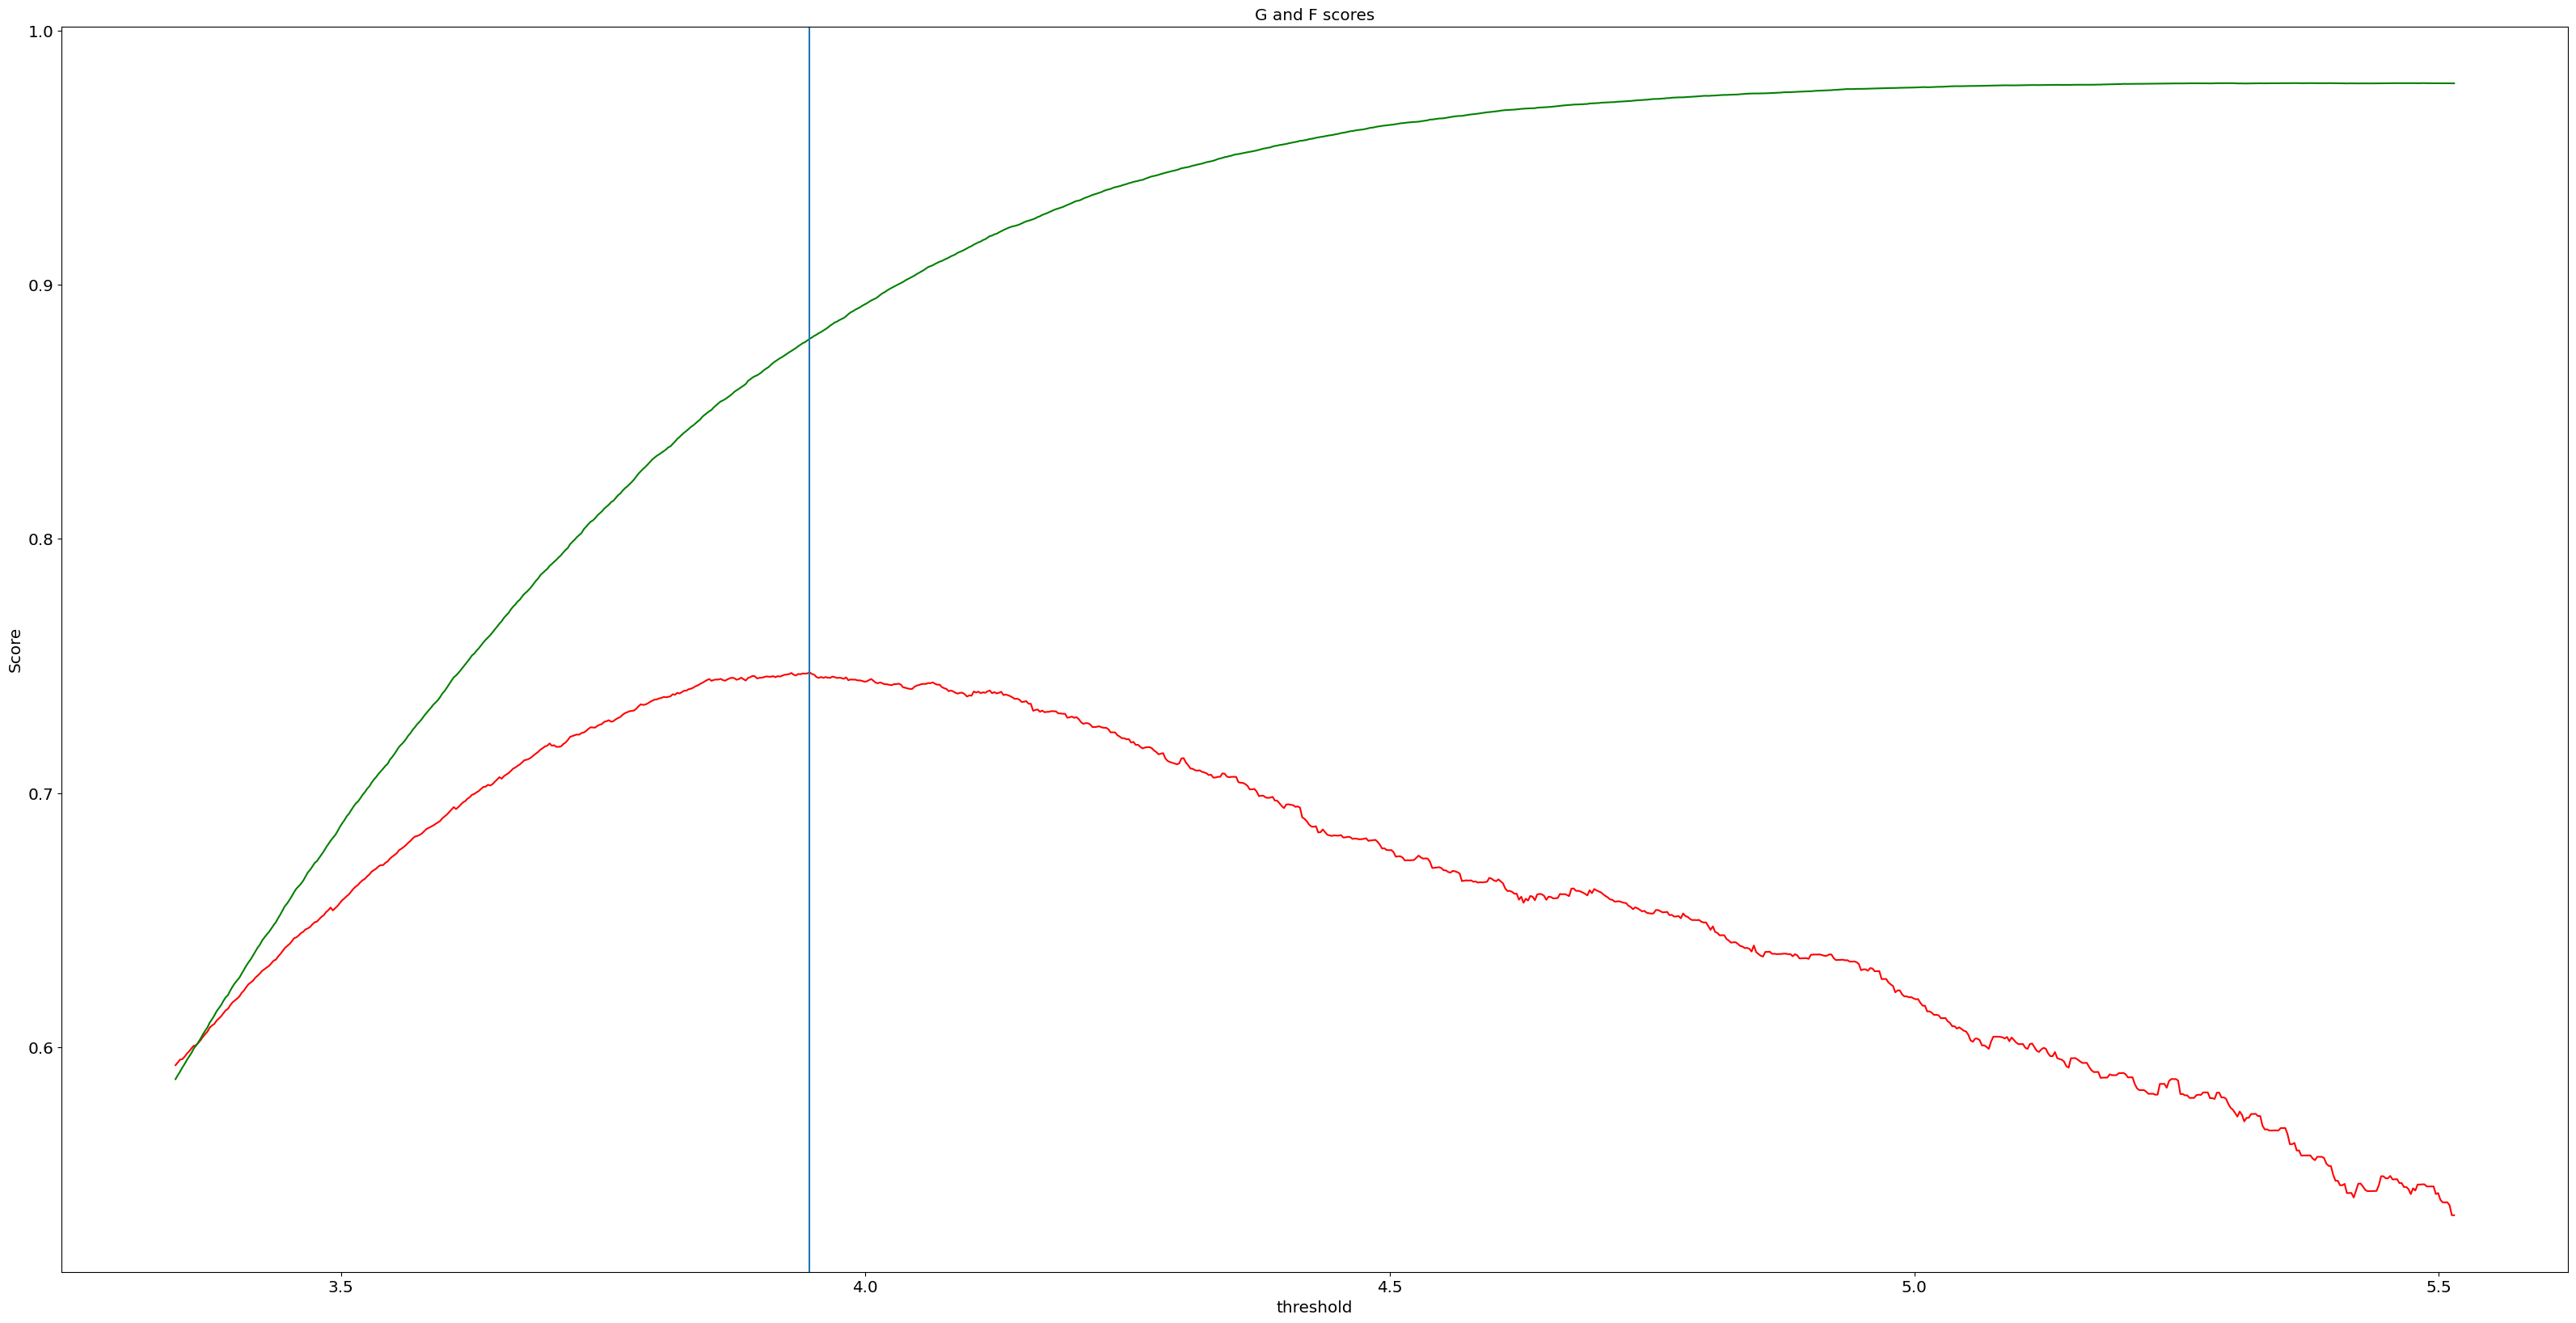

In [99]:
# Initialise the subplot function using number of rows and columns
# Plotting both the curves simultaneously
plt.plot(thresholds, g_values, color='r', label='G score')
plt.plot(thresholds, f1_values, color='g', label='F1 score')

plt.axvline(x=top_thresh)
    
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("threshold")
plt.ylabel("Score")
plt.title("G and F scores")

plt.show()

In [67]:
def draw_hist(data, title):
    std = np.std(data)
    mean = np.mean(data)
    median = np.median(data)
    var = np.var(data)
    
    bin_size = 100
    
    fig, ax = plt.subplots()
    
    counts, bins, _ = ax.hist(data, bins=bin_size) # density=1
    avg = bins[np.argmax(counts)]
    
    ax.axvline(avg - std, 0, 1, label='std left', color='r')
    ax.axvline(median, 0, 1, label='median', color='g')
    ax.axvline(top_thresh, 0, 1, label='top_thresh', color='c', linestyle = '--')
    ax.axvline(avg + std, 0, 1, label='std right', color='r') 
    ax.legend()
    
    y = ((1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * (1 / std * (bins - mean))**2))
#     ax.plot(bins, y, '--')
    ax.set_title(f'Distribution of distances for the data set: {title} $\sigma={round(std, 3)}$:  | $\mu={round(median, 3)}$:  | avg: {round(avg, 3)}')
    ax.set_xlabel(f'Distance (bin size = {bin_size})')
    ax.set_ylabel('Count')
    fig.tight_layout()
    plt.show()
    
    sigma_1x = sum([True if i > (avg - std) and i < (avg + std) else False for i in data])
    sigma_2x = sum([True if i > (avg - 2 * std) and i < (avg + 2 * std) else False for i in data])
    sigma_3x = sum([True if i > (avg - 3 * std) and i < (avg + 3 * std) else False for i in data])
    coef_var = std/mean
    print(f'coefficient variance: {coef_var}')
    print(f'68–95–99.7 rule: |{sigma_1x/ len(data)}|{sigma_2x/ len(data)}|{sigma_3x/ len(data)}|')
    return counts, bins

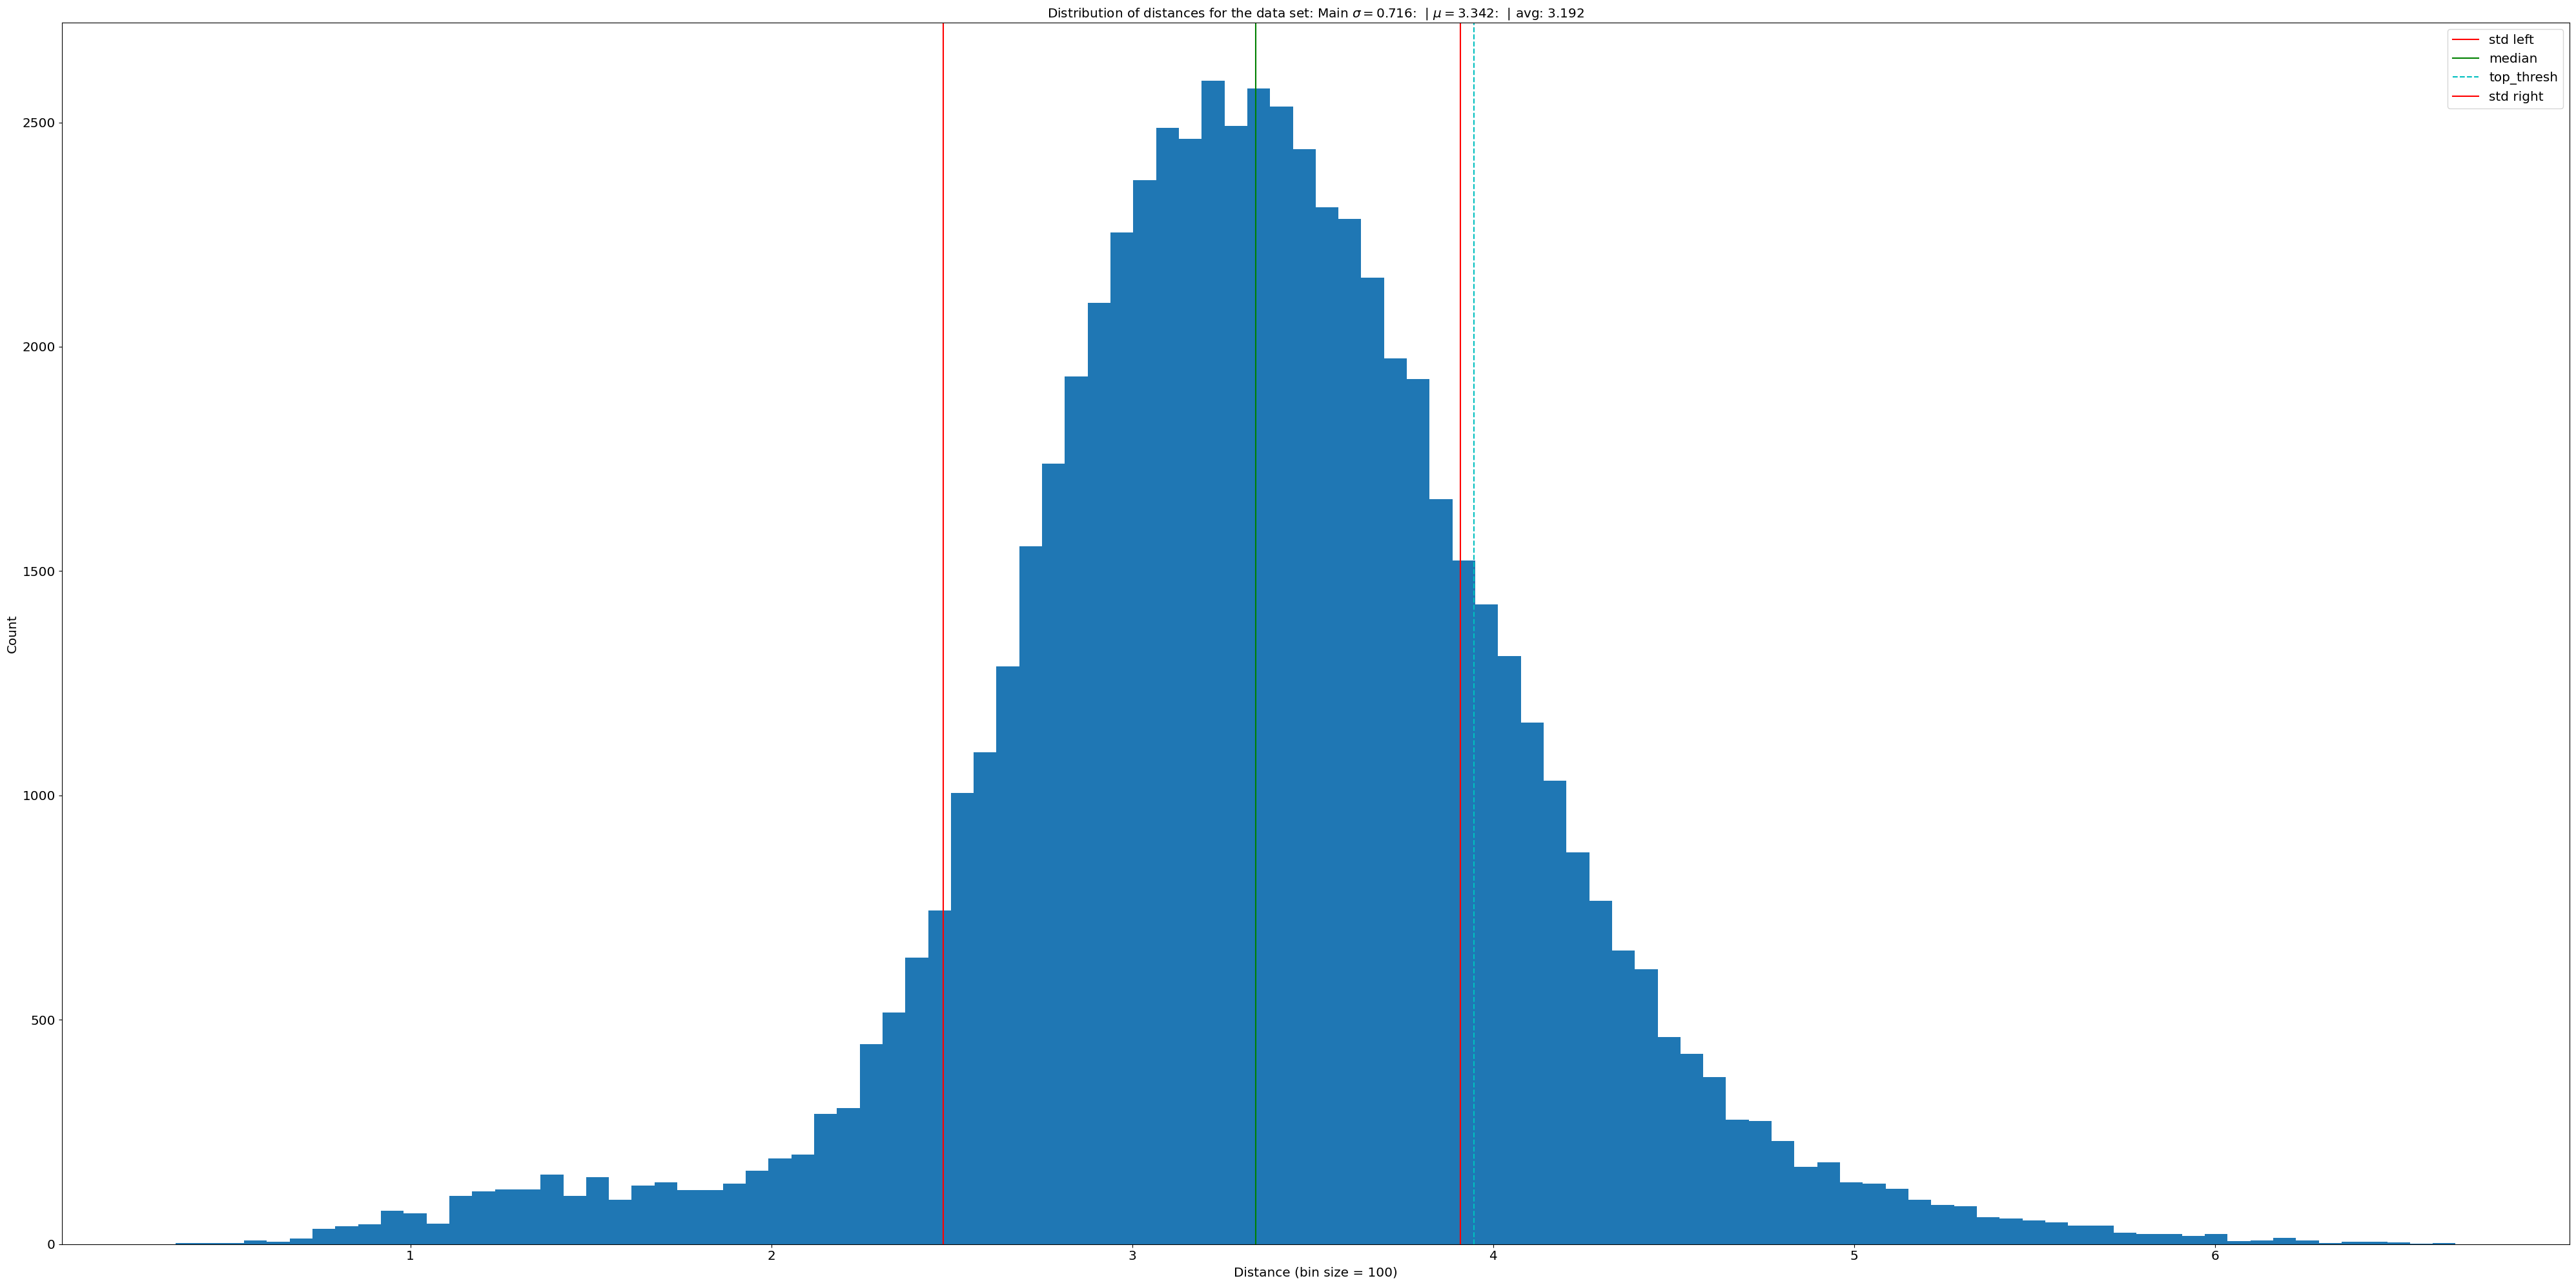

coefficient variance: 0.2135811472904158
68–95–99.7 rule: |0.7241200339718789|0.9371048409927338|0.9880469315214998|


Text(0, 0.5, 'Count')

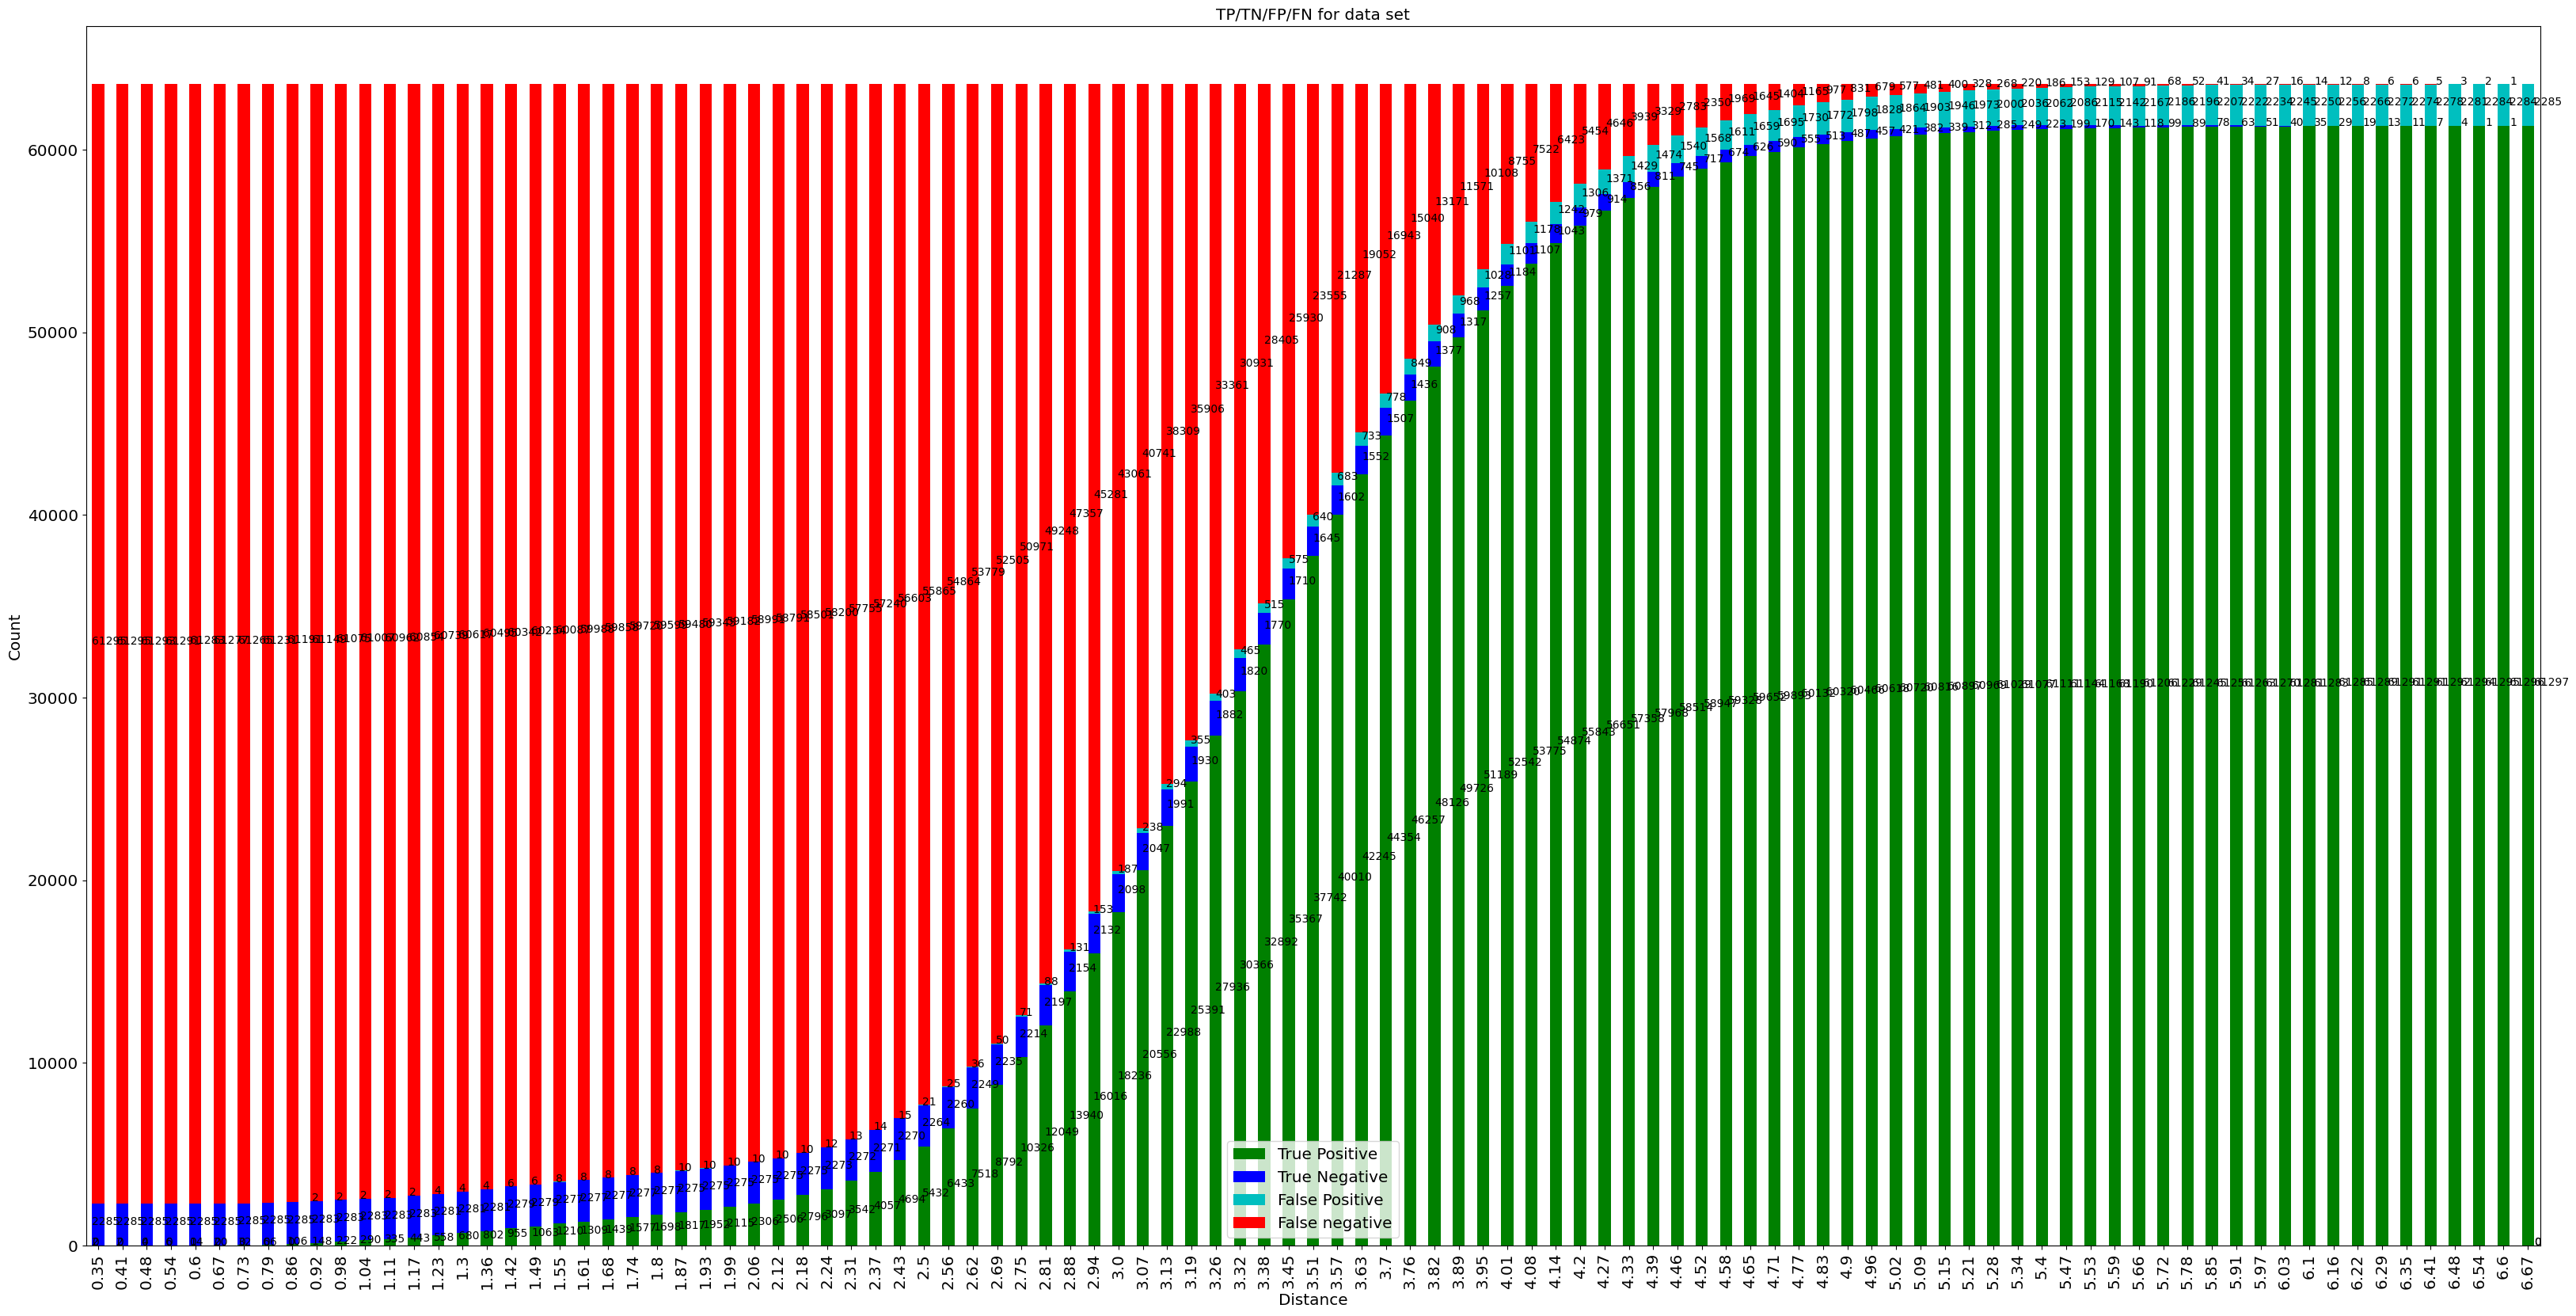

In [68]:
#print(f"Name: {data_set}")
data_plot = np.array([k for z in data_sets for k in data_sets[z]['distance']])
truth_map = [z == k for z in data_sets for k in data_sets[z]['pred']]

counts, bins = draw_hist(data_plot, "Main")
bins_count_true_pos   = [0] * len(bins)
bins_count_true_neg   = [0] * len(bins)
bins_count_false_pos  = [0] * len(bins)
bins_count_false_neg  = [0] * len(bins)

for bin_id, bin_i in enumerate(bins):
    for label_truth_id, label_truth in enumerate(truth_map):

        if data_plot[label_truth_id] <= bin_i:       
            if label_truth:
                bins_count_true_pos[bin_id]   += 1
            else:
                bins_count_false_pos[bin_id]  += 1
        else:
            if label_truth:
                bins_count_false_neg[bin_id]  += 1
            else:
                bins_count_true_neg[bin_id]   += 1

plotdata = pd.DataFrame({
    "True Positive" : bins_count_true_pos,
    "True Negative" : bins_count_true_neg,
    "False Positive": bins_count_false_pos,
    "False negative": bins_count_false_neg},
    index=[round(bin, 2) for bin in bins])

ax = plotdata.plot(kind='bar', stacked=True, color= ['g', 'b', 'c', 'r'])
for sss, p in enumerate(ax.patches):
    bias = sss % 4
    ax.annotate(str(int(p.get_height())), (p.get_x() * 1.005, p.get_y() + p.get_height()/2 ))

plt.title(f"TP/TN/FP/FN for data set")
plt.xlabel("Distance")
plt.ylabel("Count")

## correlation matrix

In [137]:
y_true = []
y_pred = []

for label in data_sets:
    if label == 'Other': continue

    y_true.extend([label] * len(data_sets[label]['pred']))
    y_pred.extend(data_sets[label]['pred'])

In [ ]:
# cm = confusion_matrix(y_true, y_pred, normalize='true')
# fig, ax = plt.subplots(figsize=(30, 30))
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp = disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=90)
# plt.title(f"Data:")
# plt.show()

In [151]:
from tabulate import tabulate
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import precision_recall_fscore_support

print(classification_report(y_true, y_pred))

|                                    |   precision |   recall |   f1-score |    support |
|:-----------------------------------|------------:|---------:|-----------:|-----------:|
| Opisthonema oglinum                |      1.0000 |   0.9773 |     0.9885 |    44.0000 |
| Sphyrna mokarran                   |      0.9375 |   0.9375 |     0.9375 |    48.0000 |
| Hiodon alosoides                   |      1.0000 |   0.9388 |     0.9684 |    49.0000 |
| Neogobius melanostomus             |      0.9800 |   0.9608 |     0.9703 |    51.0000 |
| Squalus acanthias                  |      0.9574 |   0.8824 |     0.9184 |    51.0000 |
| Leuciscus aspius                   |      0.9623 |   0.9623 |     0.9623 |    53.0000 |
| Xiphias gladius                    |      0.9630 |   0.9811 |     0.9720 |    53.0000 |
| Lutjanus cyanopterus               |      0.9464 |   0.9636 |     0.9550 |    55.0000 |
| Acroteriobatus annulatus           |      1.0000 |   0.9828 |     0.9913 |    58.0000 |
| Clupea h

In [ ]:
list_numbers = random.choices([100,100], k=200) 
random_numbers = torch.Tensor(list_numbers)

main_folder = '../../output/train_results/resnet_18_200'
data_distance_disturb = {}
set_names = ['data_train.json_embedding.pt', 'data_test.json_embedding.pt', 'data_remain.json_embedding.pt']
for i in zip(
    set_names,
    ['data_train.json_labels.json', 'data_test.json_labels.json', 'data_remain.json_labels.json']):
    
    data_base = torch.load(os.path.join(main_folder, i[0])).to('cpu')
    data_labels_by_data = read_json(os.path.join(main_folder, i[1]))
    
    data_distance_disturb.update({
        i[0]: {
            'labels': {
            data_labels[label]: {       
            'distance': [] 
    } for label in data_labels}}})
    
    for label_id in range(len(data_base)):
        print(f"Current: {label_id} | {i[0]}", end = '\r')
        for first_id, first_vec in enumerate(data_base[label_id]):
            for second_id, second_vec in enumerate(data_base[label_id]):
                if first_vec.sum() > 1000 or second_vec.sum() > 1000: continue
                diff = (first_vec - second_vec).pow(2).sum().sqrt()
                if diff == 0: continue
                data_distance_disturb[i[0]]['labels'][data_labels_by_data[str(label_id)]]['distance'].append(diff)
    

In [ ]:
data_set = 'data_test.json_embedding.pt'
for z in data_distance_disturb[data_set]['labels']:

    data_train = np.array([float(k.detach().numpy()) for k in data_distance_disturb[set_names[0]]['labels'][z]['distance']])
    data_test = np.array([float(k.detach().numpy()) for k in data_distance_disturb[set_names[1]]['labels'][z]['distance']])
    data_remain = np.array([float(k.detach().numpy()) for k in data_distance_disturb[set_names[2]]['labels'][z]['distance']])

    bin_size = 60

    fig, ax = plt.subplots()

    counts, bins, _ = ax.hist(data_train, bins=bin_size, label='data_train', density=1, alpha=0.5) # density=1
    counts, bins, _ = ax.hist(data_test, bins=bin_size, label='data_test', density=1, alpha=0.5) # density=1
    counts, bins, _ = ax.hist(data_remain, bins=bin_size, label='data_remain', density=1, alpha=0.5) # density=1

    ax.axvline(4, 0, 1, label='Threshold', color='g', linestyle = '--')
    ax.legend()
    
    ax.set_title(f'Distribution of distances for the data set: {z}')
    ax.set_xlabel(f'Distance (bin size = {bin_size})')
    ax.set_ylabel('Count')
    fig.tight_layout()
    print(f'Train: {len(data_train)} Test: {len(data_test)} Remain: {len(data_remain)}')
    plt.show()

## Distribution of distances for each class.

In [ ]:
def get_stats(distances):
    data = np.array([i.detach().numpy() for i in distances])
    precision = 2
    std    = round(float(np.std(data)), 2)
    mean   = round(float(np.mean(data)), 2)
    median = round(float(np.median(data)), 2)
    return std, mean, median

dict_stats = {
    'cnt_train'    : [],
    'std_train'    : [],
    'mean_train'   : [],
    'median_train' : [],
    'cnt_test'     : [],
    'std_test'     : [],
    'mean_test'    : [],
    'median_test'  : [],
    'cnt_remain'   : [],
    'std_remain'   : [],
    'mean_remain'  : [],
    'median_remain': []
}
for label in [data_labels[iddx] for iddx in data_labels]:
    
    std_train, mean_train, median_train = get_stats(data_distance_disturb['data_train.json_embedding.pt']['labels'][label]['distance'])
    dict_stats['cnt_train'].append(len(data_distance_disturb['data_train.json_embedding.pt']['labels'][label]['distance']))
    dict_stats['mean_train'].append(mean_train)
    dict_stats['median_train'].append(median_train)
    dict_stats['std_train'].append(std_train)
    
    std_test, mean_test, median_test = get_stats(data_distance_disturb['data_test.json_embedding.pt']['labels'][label]['distance'])
    dict_stats['cnt_test'].append(len(data_distance_disturb['data_test.json_embedding.pt']['labels'][label]['distance']))
    dict_stats['mean_test'].append(mean_test)
    dict_stats['median_test'].append(median_test)
    dict_stats['std_test'].append(std_test)
    
    std_remain, mean_remain, median_remain = get_stats(data_distance_disturb['data_remain.json_embedding.pt']['labels'][label]['distance'])
    dict_stats['cnt_remain'].append(len(data_distance_disturb['data_remain.json_embedding.pt']['labels'][label]['distance']))
    dict_stats['mean_remain'].append(mean_remain)
    dict_stats['median_remain'].append(median_remain)
    dict_stats['std_remain'].append(std_remain)
#     count, bins = draw_hist(data_sets['train']['labels'][label]['distance'], label)
df = pd.DataFrame(dict_stats, index =[data_labels[iddx] for iddx in data_labels] )

writer = pd.ExcelWriter('output.xlsx')
# write dataframe to excel sheet named 'marks'
df.to_excel(writer, 'marks')
# save the excel file
writer.save()
print('DataFrame is written successfully to Excel Sheet.')


In [150]:
def classification_report(y_true, y_pred, labels=None, target_names=None,
                          sample_weight=None, digits=4, tablfmt='pipe'):
    """  Better format for sklearn's classification report
    Based on tabulate package
    ----------
    y_true : 1d array-like, or label indicator array / sparse matrix
        Ground truth (correct) target values.
    y_pred : 1d array-like, or label indicator array / sparse matrix
        Estimated targets as returned by a classifier.
    labels : array, shape = [n_labels]
        Optional list of label indices to include in the report.
    target_names : list of strings
        Optional display names matching the labels (same order).
    sample_weight : array-like of shape = [n_samples], optional
        Sample weights.
    digits : int
        Number of digits for formatting output floating point values
    Returns
    -------
    report : string
        Text summary of the precision, recall, F1 score for each class.
        The reported averages are a prevalence-weighted macro-average across
        classes (equivalent to :func:`precision_recall_fscore_support` with
        ``average='weighted'``).
        Note that in binary classification, recall of the positive class
        is also known as "sensitivity"; recall of the negative class is
        "specificity".
    Examples
    --------
    >>> from sklearn.metrics import classification_report
    >>> y_true = [0, 1, 2, 2, 2]
    >>> y_pred = [0, 0, 2, 2, 1]
    >>> target_names = ['class 0', 'class 1', 'class 2']
    >>> print(classification_report(y_true, y_pred, target_names=target_names))
                 precision    recall  f1-score   support
    """
    floatfmt = '.{:}f'.format(digits)
    if labels is None:
        labels = unique_labels(y_true, y_pred)
    else:
        labels = np.asarray(labels)

    if target_names is not None and len(labels) != len(target_names):
        print(
            "labels size, {0}, does not match size of target_names, {1}"
            .format(len(labels), len(target_names))
        )

    last_line_heading = 'avg / total'

    if target_names is None:
        target_names = [u'%s' % l for l in labels]

    headers = ["precision", "recall", "f1-score", "support"]

    p, r, f1, s = precision_recall_fscore_support(y_true, y_pred,
                                                  labels=labels,
                                                  average=None,
                                                  sample_weight=sample_weight)

    rows = zip(target_names, p, r, f1, s)
    tbl_rows = []
    for row in rows:
        tbl_rows.append(row)

    # compute averages
    last_row = (last_line_heading,
                np.average(p, weights=s),
                np.average(r, weights=s),
                np.average(f1, weights=s),
                np.sum(s))
    tbl_rows.append(last_row)
    tbl_rows = sorted(tbl_rows, key=lambda x: x[4])
    return tabulate(tbl_rows, headers=headers,
                    tablefmt=tablfmt, floatfmt=floatfmt)